# AoA方式

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from lmfit.models import SineModel
from scipy.optimize import curve_fit
from typing import Optional
import sympy as sp
from sympy.plotting import plot3d
from components import point2d as p2
from components import point3d as p3
from components import antennaPair as antp
from components import antenna as ant
import itertools
%matplotlib inline

In [40]:
c = 2.998e8 #光の速度
f = 920.4e6 #周波数
WAVE_LENGTH = c / f * 100 #理論波長
THETA_M = 34 * np.pi / 180
MAX_L = WAVE_LENGTH / (2 * np.sin(THETA_M))
L = 25
BETA = 2
DATA_LENGTH = 10
print(f'波長λ:{WAVE_LENGTH}, Lの最大値:{MAX_L}')
R=45

波長λ:32.57279443720122, Lの最大値:29.124828154140907


In [41]:
RSSI0_DATA_FILE_PATH = '..//data//RSSI0_GTag.csv'

In [42]:
DATA_FILE_PATH_LIST=[
    '..//data//triangulation_GTag_p40.csv',
    '..//data//triangulation_GTag_p35.csv',
    '..//data//triangulation_GTag_p30.csv',
    '..//data//triangulation_GTag_p25.csv',
    '..//data//triangulation_GTag_p20.csv',
    '..//data//triangulation_GTag_p15.csv',
    '..//data//triangulation_GTag_p10.csv',
    '..//data//triangulation_GTag_p5.csv',
    '..//data//triangulation_GTag_0.csv',
    '..//data//triangulation_GTag_m5.csv',
    '..//data//triangulation_GTag_m10.csv',
    '..//data//triangulation_GTag_m15.csv',
    '..//data//triangulation_GTag_m20.csv',
    '..//data//triangulation_GTag_m25.csv',
    '..//data//triangulation_GTag_m30.csv',
    '..//data//triangulation_GTag_m35.csv',
    '..//data//triangulation_GTag_m40.csv',
]

DATA_FILE_PATH_LIST2=[
    '..//data//aoa_p30_50cm.csv',
    '..//data//aoa_p30_60cm.csv',
    '..//data//aoa_p30_70cm.csv',
    '..//data//aoa_p30_80cm.csv',
    '..//data//aoa_p30_90cm.csv',
    '..//data//aoa_p30_100cm.csv',
    '..//data//aoa_p30_110cm.csv',
    '..//data//aoa_p30_120cm.csv',
    '..//data//aoa_p30_130cm.csv',
    '..//data//aoa_p30_140cm.csv',
    '..//data//aoa_p30_150cm.csv'
]

DATA_FILE_PATH_LIST3=[
    '..//data//aoa_p40.csv',
    '..//data//aoa_p30.csv',
    '..//data//aoa_p20.csv',
    '..//data//aoa_p10.csv',
    '..//data//aoa_0.csv',
    '..//data//aoa_m10.csv',
    '..//data//aoa_m20.csv',
    '..//data//aoa_m30.csv',
    '..//data//aoa_m40.csv'
]

In [43]:
TARGET_TAG = 'E200 470F C1A0 6023 A8E6 010F'

In [44]:
ANTENNA_PAIR_LIST = {
    'Pair1' : [ant.Antenna(point=p3.Point3d(-12.5, 0, 0), frequency=920.4, number=6, theta_m=34),ant.Antenna(point=p3.Point3d(12.5, 0, 0), frequency=920.4, number=4, theta_m=34)],
    # 'PairY' : [ant.Antenna(point=p3.Point3d(0, 0, 0), frequency=920.4, number=5, theta_m=34),ant.Antenna(point=p3.Point3d(0, 25.0, 0), frequency=920.4, number=6, theta_m=34)]
}

In [45]:
ANGLE_RANGE = range(int(-(len(DATA_FILE_PATH_LIST)-1)/2*5), int((len(DATA_FILE_PATH_LIST)-1)/2*5+5), 5)
R1_LIST = [np.sqrt(pow(R, 2) + pow((L/2), 2) - R * L * np.sin((i) * np.pi / 180)) for i in ANGLE_RANGE]
R2_LIST = [np.sqrt(pow(R, 2) + pow((L/2), 2) + R * L * np.sin((i) * np.pi / 180)) for i in ANGLE_RANGE]
ACTUAL_PHASE1 = [(-4 * np.pi / WAVE_LENGTH * R1_LIST[i]) % (2 * np.pi)  for i in range(0,len(DATA_FILE_PATH_LIST))]
ACTUAL_PHASE2 = [(-4 * np.pi / WAVE_LENGTH * R2_LIST[i]) % (2 * np.pi) for i in range(0,len(DATA_FILE_PATH_LIST))]
R_RANGE = range(50, 160, 10)
R1_LIST_LENGTH = [np.sqrt(pow(r, 2) + pow((L/2), 2) - r * L * np.sin(-30 * np.pi / 180)) for r in R_RANGE]
R2_LIST_LENGTH = [np.sqrt(pow(r, 2) + pow((L/2), 2) + r * L * np.sin(-30 * np.pi / 180)) for r in R_RANGE]

In [46]:
DELTA_PHI0_FILE_PATH = '..//data//triangulation_GTag_0.csv'

In [47]:
FIG_COLOR_LIST = [
    
]

In [48]:
class RfidDf:
    def __init__(self, csv_file:str, rssi0_cav_file:str, phi0_file:str, antenna_pair_list:dict, target_tag:str, beta:float):
        self.df=pd.read_csv(csv_file)
        self.phi0_df = pd.read_csv(phi0_file)
        self.data_size = len(self.df)
        self.antenna_pair_list = antenna_pair_list
        self.target_tag = target_tag
        self.beta = beta
        self.rssi0_csv_file = rssi0_cav_file
        self.df = self.df[self.df['Tag ID'] == self.target_tag]
        self.df['Antenna Pair No.'] = self.df['Antenna No.'].apply(self.__get_antenna_pair_number)
        self.df['Phase'] = self.df['Phase'].astype(float)
        self.df['RSSI'] = self.df['RSSI'].astype(float)
        self.df = self.df.drop(['Tag ID'], axis=1).set_index(['Antenna Pair No.', 'Antenna No.', 'Data Number'])
        self.phi0_df = self.phi0_df[self.phi0_df['Tag ID'] == self.target_tag]
        self.phi0_df['Antenna Pair No.'] = self.phi0_df['Antenna No.'].apply(self.__get_antenna_pair_number)
        self.phi0_df['Phase'] = self.phi0_df['Phase'].astype(float)
        self.phi0_df['RSSI'] = self.phi0_df['RSSI'].astype(float)
        self.phi0_df = self.phi0_df.drop(['Tag ID'], axis=1).set_index(['Antenna Pair No.', 'Antenna No.', 'Data Number'])
    
    def __get_antenna_pair_number(self, antenna_number:int):
        for k in self.antenna_pair_list:
            for i in self.antenna_pair_list[k]:
                if i.number == antenna_number:
                    return k

    def __cul_rssi0(self, antenna:ant):
        df=pd.read_csv(self.rssi0_csv_file)
        antenna_number = antenna.number
        return df[df['Antenna No.']==antenna_number]['RSSI'].mean()
    
    def __cul_distance(self, rssi:float, antenna:ant) -> float:
        return float(pow(10, (self.__cul_rssi0(antenna) - rssi)/(10 * self.beta)) * 100)

    def __cul_angle_from_phase(self, phase1:float, phase2:float, rssi1:float, rssi2:float) -> float:
        phi0 = self.get_phi0()
        delta_phi = (phase1-phase2)-(phi0[0]-phi0[1])
        if (delta_phi >= 0) & (rssi1 < rssi2):
            delta_phi = delta_phi - 2 * np.pi
        if (delta_phi < 0) & (rssi1 >= rssi2):
            delta_phi = delta_phi + 2 * np.pi
        return np.arcsin(WAVE_LENGTH / (4 * np.pi * L) * delta_phi) * 180 / np.pi

    def __cul_angle_from_rssi(self, l, rssi1, rssi2, antenna1:ant, antenna2:ant):
        r1 = self.__cul_distance(rssi1, antenna1)
        r2 = self.__cul_distance(rssi2, antenna2)
        return np.arcsin((r2 - r1)/l) * 180 / np.pi

    def get_phi0(self):
        ant1_phi0=0
        ant2_phi0 = 0
        for pair in self.antenna_pair_list:
            ant1 = self.antenna_pair_list[pair][0]
            ant2 = self.antenna_pair_list[pair][1]
            ant1_phi0 = self.phi0_df.sort_index().loc[(pair, ant1.number)]['Phase'].mean() + ACTUAL_PHASE1[8]
            ant2_phi0 = self.phi0_df.sort_index().loc[(pair, ant2.number)]['Phase'].mean() + ACTUAL_PHASE1[8]
        return [ant1_phi0, ant2_phi0]

    def get_angle_list_from_phase(self):
        phi0_list = self.get_phi0()
        data_array = np.empty((0, 6))
        for pair in self.antenna_pair_list:
            ant1 = self.antenna_pair_list[pair][0]
            ant2 = self.antenna_pair_list[pair][1]
            for i in range(0, DATA_LENGTH):
                phi0 = self.get_phi0()
                ant1_phase = (self.df.xs((pair, ant1.number, i))['Phase']) % (2 * np.pi)
                ant2_phase = (self.df.xs((pair, ant2.number, i))['Phase']) % (2 * np.pi)
                ant1_rssi = self.df.xs((pair, ant1.number, i))['RSSI']
                ant2_rssi = self.df.xs((pair, ant2.number, i))['RSSI']
                angle = self.__cul_angle_from_phase(ant1_phase, ant2_phase, ant1_rssi, ant2_rssi)
                data_array = np.append(
                    data_array,
                    [[
                        pair, i,(ant1_phase-phi0[0]) % (2*np.pi), (ant2_phase-phi0[1]) % (2 * np.pi) , ant1_phase-ant2_phase-phi0[0]+phi0[1], angle
                    ]],
                    axis=0
                )
        df = pd.DataFrame(
            data=data_array,
            columns=['Antenna Pair No.', 'Data Number', 'Phase1', 'Phase2', 'Phase Diff', 'Angle']
        ).set_index(['Antenna Pair No.', 'Data Number'])
        df['Phase1'] = df['Phase1'].astype(float)
        df['Phase2'] = df['Phase2'].astype(float)
        df['Phase Diff'] = df['Phase Diff'].astype(float)
        df['Angle'] = df['Angle'].astype(float)
        return df

    def get_angle_list_from_rssi(self):
        data_array = np.empty((0, 5))
        for pair in self.antenna_pair_list:
            ant1 = self.antenna_pair_list[pair][0]
            ant2 = self.antenna_pair_list[pair][1]
            for i in range(0, DATA_LENGTH):
                ant1_rssi = self.df.xs((pair, i, ant1.number))['RSSI']
                ant2_rssi = self.df.xs((pair, i, ant2.number))['RSSI']
                angle = self.__cul_angle_from_rssi(ant1.cul_distance_to_antenna(ant2), ant1_rssi, ant2_rssi, ant1, ant2)
                data_array = np.append(
                    data_array,
                    [[
                        pair, i, self.__cul_distance(ant1_rssi, ant1), self.__cul_distance(ant2_rssi, ant2), angle
                    ]],
                    axis=0
                )
        df = pd.DataFrame(
            data=data_array,
            columns=['Antenna Pair No.', 'Data Number', 'R1', 'R2', 'Angle']
        ).set_index(['Antenna Pair No.', 'Data Number'])
        df['R1'] = df['R1'].astype(float)
        df['R2'] = df['R2'].astype(float)
        df['Angle'] = df['Angle'].astype(float)
        return df

In [49]:
triangulation_list = []
angle_phase_list = []
angle_phase_mean_list = []
phase_diff_mean_list = []
ant1_phase_mean_list = []
ant2_phase_mean_list = []
triangulation_list2 = []
angle_phase_list2 = []
angle_phase_mean_list2 = []
phase_diff_mean_list2 = []
ant1_phase_mean_list2 = []
ant2_phase_mean_list2 = []
ant1_sin_list = []
ant2_sin_list = []
sin_diff_list=[]
for i in range(0, len(DATA_FILE_PATH_LIST)):
    triangulation_list.append(
        RfidDf(
            phi0_file=DATA_FILE_PATH_LIST[8],
            rssi0_cav_file=RSSI0_DATA_FILE_PATH,
            csv_file=DATA_FILE_PATH_LIST[i],
            antenna_pair_list=ANTENNA_PAIR_LIST,
            target_tag=TARGET_TAG,
            beta=BETA,
        )
    )
    angle_phase_mean_list.append(triangulation_list[i].get_angle_list_from_phase()['Angle'].mean())
    phase_diff_mean_list.append(triangulation_list[i].get_angle_list_from_phase()['Phase Diff'].mean())
    ant1_phase_mean_list.append(triangulation_list[i].get_angle_list_from_phase()['Phase1'].mean())
    ant2_phase_mean_list.append(triangulation_list[i].get_angle_list_from_phase()['Phase2'].mean())
for i in range(0, len(DATA_FILE_PATH_LIST2)):
    triangulation_list2.append(
        RfidDf(
            phi0_file=DATA_FILE_PATH_LIST[8],
            rssi0_cav_file=RSSI0_DATA_FILE_PATH,
            csv_file=DATA_FILE_PATH_LIST2[i],
            antenna_pair_list=ANTENNA_PAIR_LIST,
            target_tag=TARGET_TAG,
            beta=BETA,
        )
    )
    angle_phase_mean_list2.append(triangulation_list2[i].get_angle_list_from_phase()['Angle'].mean())
    phase_diff_mean_list2.append(triangulation_list2[i].get_angle_list_from_phase()['Phase Diff'].mean())
    ant1_phase_mean_list2.append(triangulation_list2[i].get_angle_list_from_phase()['Phase1'].mean())
    ant2_phase_mean_list2.append(triangulation_list2[i].get_angle_list_from_phase()['Phase2'].mean())
    ant1_sin_list.append(np.sin(triangulation_list2[i].get_angle_list_from_phase()['Phase1'].mean()))
    ant2_sin_list.append(np.sin(triangulation_list2[i].get_angle_list_from_phase()['Phase2'].mean()))
    sin_diff_list.append(np.sin(triangulation_list2[i].get_angle_list_from_phase()['Phase1'].mean())-np.sin(triangulation_list2[i].get_angle_list_from_phase()['Phase2'].mean()))

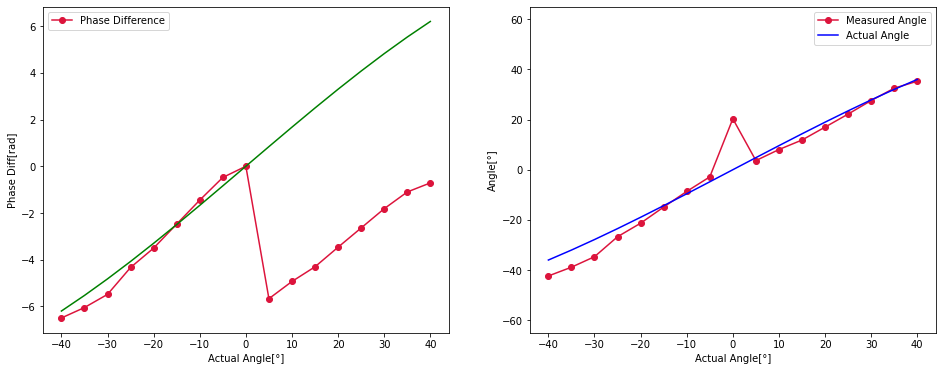

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(ANGLE_RANGE, phase_diff_mean_list, marker='o', label=f'Phase Difference', color='crimson')
ax1.plot(ANGLE_RANGE, [4 * np.pi * L / WAVE_LENGTH * np.sin(theta * np.pi / 180) for theta in ANGLE_RANGE], color="green")
ax1.set_ylabel('Phase Diff[rad]')
ax1.set_xlabel('Actual Angle[°]')
ax1.legend()
ax2.plot(ANGLE_RANGE, angle_phase_mean_list, marker='o', label='Measured Angle', color='crimson')
ax2.plot(ANGLE_RANGE, [-(R1_LIST[i]-R2_LIST[i]) / L * 180 / np.pi for i in range(0, len(DATA_FILE_PATH_LIST))], label='Actual Angle', color='blue')
ax2.set_ylim(-65, 65)
ax2.set_ylabel('Angle[°]')
ax2.set_xlabel('Actual Angle[°]') 
ax2.legend()

In [51]:
actual_phase_length1 = [(-4 * np.pi * r1 / WAVE_LENGTH)  for r1 in R1_LIST_LENGTH]
actual_phase_length2 = [(-4 * np.pi * r2 / WAVE_LENGTH)  for r2 in R2_LIST_LENGTH]
actual_phase_diff = [actual_phase_length1[i]-actual_phase_length2[i] for i in range(0, len(DATA_FILE_PATH_LIST2))]
actual_angle = [np.arcsin(WAVE_LENGTH / (4 * np.pi * L) * actual_phase_diff[i]) * 180 / np.pi for i in range(0, len(DATA_FILE_PATH_LIST2))]

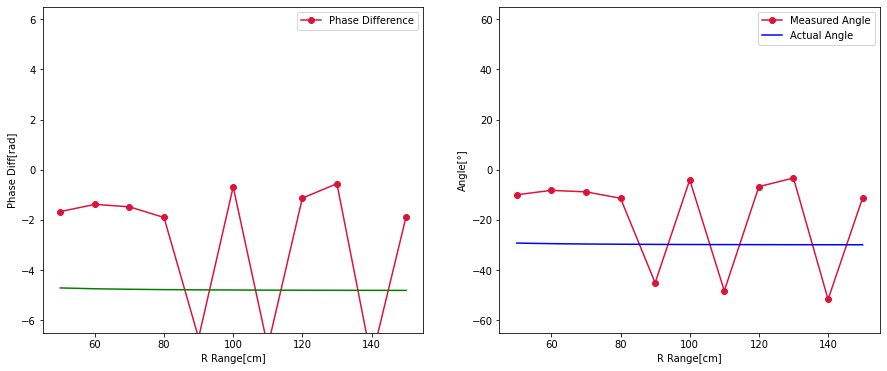

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(R_RANGE, phase_diff_mean_list2, marker='o', label=f'Phase Difference', color='crimson')
ax1.plot(R_RANGE, actual_phase_diff, color="green")
ax1.set_ylim(-6.5, 6.5)
ax1.set_xlabel('R Range[cm]') 
ax1.set_ylabel('Phase Diff[rad]')
ax1.legend()
ax2.plot(R_RANGE, angle_phase_mean_list2, marker='o', label='Measured Angle', color='crimson')
ax2.plot(R_RANGE, actual_angle, label='Actual Angle', color='blue')
ax2.set_ylim(-65, 65)
ax2.set_ylabel('Angle[°]')
ax2.set_xlabel('R Range[cm]') 
ax2.legend()

### 測定可能範囲の計算

[-57.2957795130823*asin(0.6514*sqrt(r**2 + 0.008994969375)/r) + 57.2957795130823*pi, 57.2957795130823*asin(0.6514*sqrt(r**2 + 0.008994969375)/r) + 57.2957795130823*pi, -57.2957795130823*asin(0.6514*sqrt(r**2 + 0.008994969375)/r), 57.2957795130823*asin(0.6514*sqrt(r**2 + 0.008994969375)/r)]


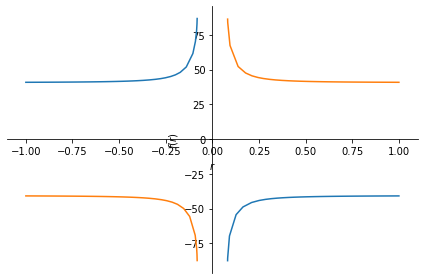

In [69]:
r, t, l, lam = sp.symbols('r, t, l, lam')

sol = sp.solve(sp.sqrt(r**2 + (l/2)**2 + r*l*sp.sin(t))-sp.sqrt(r**2 + (l/2)**2 - r*l*sp.sin(t)) - lam/2, t)

new_sol = [i.subs([(l, 0.25), (lam, 0.3257)]) /2 /np.pi * 360 for i in sol]

print(new_sol)
sp.plot(
    new_sol[2],new_sol[3], (r, -1, 1)
)